
In this notebook we are going to apply the LDA model on a dataset 
containing 600+ transcript edited with the easy movie framework.

# Objective

* Study the metadata of the videos transcripts 
* Determine K topics labels. 
* Determine the best K value for the LDA with GridSearch.
* Train the LDA and export it to use it in the MAcOS labelling software (Sophia).

# Strategy 

* Cleaning the data. 
* Use grid-earch to find the best K value. 
* Determine the tag name for each topic.

Note : This dataset is tiny and we don't know if it's well balance 
so the topic that we will be find may not be all the topics present in all 
easy movie videos. 

In [2]:
# load the dataset 

import pandas as pd 
import numpy as np


# How can we use easymovie video metadata

In [3]:
# load the dataset 

import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np


yt_df = pd.read_csv('../yt_transcripts/youtube_publications.csv', sep=",")


In [4]:
yt_df.head()

,project_id,project,customer_id,customer,date,youtube_id
0,21545.0,Timeline,720,IAD,2019-02-05 08:39:43,zxkk2GKw71s
1,22342.0,1er,720,IAD,2019-02-20 11:39:45,FL5uuhvJqVg
2,22427.0,Cycy,720,IAD,2019-02-21 12:32:16,FufeVXBlN98
3,22444.0,Paris 13e,720,IAD,2019-02-21 15:21:49,IF1oCSG8ZMM
4,22448.0,2,720,IAD,2019-02-21 15:49:51,uFlZ9v5tZYY


In [5]:
yt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1254 entries, 0 to 1253
Data columns (total 6 columns):
project_id     756 non-null float64
project        756 non-null object
customer_id    1254 non-null int64
customer       756 non-null object
date           756 non-null object
youtube_id     1254 non-null object
dtypes: float64(1), int64(1), object(4)
memory usage: 58.9+ KB


We have 6 features :

project_id : Is a unique ID use to identify a video (useless in our case)
project : Is the title of the video 
customer_id : The Unique identifier that identify a client 
customer : ___
date : Publication or edition date (useless in our case)
youtube_id : Unique identifier that identify the video on youtube => use to get the transcript online


Our objectif is to classify video by topic. I think that project_id, date and youtube_id will be useless for this task.
So we will only keep the other features. 

Customer Id and customer contains the same infos  so we could keep only one of the two. but customer have null 
value. 

In [6]:
df = yt_df[['project','customer', 'customer_id']]
df.head()

,project,customer,customer_id
0,Timeline,IAD,720
1,1er,IAD,720
2,Cycy,IAD,720
3,Paris 13e,IAD,720
4,2,IAD,720


In [7]:
df[['project','customer']].describe()

,project,customer
count,756,756
unique,674,15
top,Recrutement,IAD
freq,13,684


## Customer 

* We have 15 unique customer in the dataset with a customer value.
* Top customer is IAD.
* We have a total of 756 customer almost half of the customer features is equal to Nan

In [8]:
import seaborn as sns 

df['customer'].value_counts()

IAD                                                            684
ISEG (Ionis Education Group)                                    19
ISG (Ionis Education Group)                                     15
ISG Programme Business & Management (Ionis Education Group)     13
SUP'Internet (Ionis Education Group)                             8
Planorama                                                        3
e-artsup (Ionis Education Group)                                 2
Ionis-STM (Ionis Education Group)                                2
EasyMovie - Charte Pop                                           2
EasyMovie                                                        2
Sup'Biotech (Ionis Education Group)                              2
Epitech (Ionis Education Group)                                  1
ISG International BS (Ionis Education Group)                     1
 testeasymovie                                                   1
ESME Sudria (Ionis Education Group)                           

In [9]:
(df['customer'].value_counts() / len(df['customer'])) * 100

IAD                                                            54.545455
ISEG (Ionis Education Group)                                    1.515152
ISG (Ionis Education Group)                                     1.196172
ISG Programme Business & Management (Ionis Education Group)     1.036683
SUP'Internet (Ionis Education Group)                            0.637959
Planorama                                                       0.239234
e-artsup (Ionis Education Group)                                0.159490
Ionis-STM (Ionis Education Group)                               0.159490
EasyMovie - Charte Pop                                          0.159490
EasyMovie                                                       0.159490
Sup'Biotech (Ionis Education Group)                             0.159490
Epitech (Ionis Education Group)                                 0.079745
ISG International BS (Ionis Education Group)                    0.079745
 testeasymovie                                     

In [10]:
len(df['customer_id'].unique())

25

there are 10 unknow customers. So we have in total 25 unique customers. 

We need to study the dataset balance. Let's display the distibution of the dataset by customer_id 

In [11]:
def displayFeaturesAndDescribe(data, feature, kind='bar', color=None):
    feature_count = (df[feature].value_counts() / df.shape[0]) * 100
    feature_dataframe = pd.DataFrame()
    feature_dataframe[feature] = feature_count.index
    feature_dataframe['Percentage'] = feature_count.values
    sns.catplot(x=feature, y='Percentage', kind=kind, data=feature_dataframe, hue='Percentage', aspect=2, height=5,legend_out=True)
    

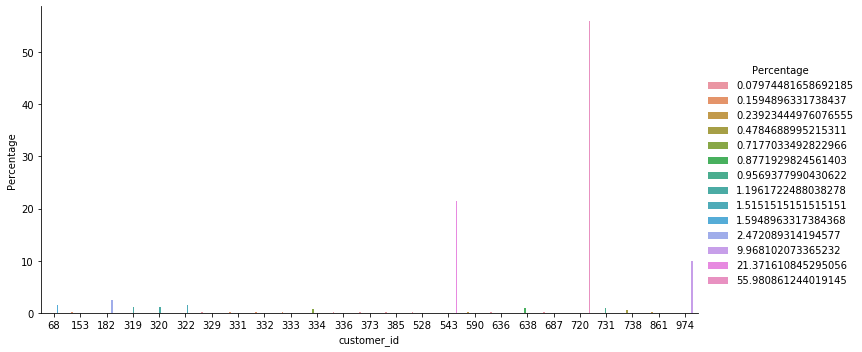

In [12]:
displayFeaturesAndDescribe(df, 'customer_id')

In [13]:
df['customer_id'].value_counts()/df['customer_id'].shape * 100

720    55.980861
543    21.371611
974     9.968102
182     2.472089
68      1.594896
322     1.515152
319     1.196172
320     1.196172
731     0.956938
638     0.877193
334     0.717703
738     0.478469
590     0.239234
861     0.239234
333     0.159490
153     0.159490
332     0.159490
331     0.159490
687     0.079745
329     0.079745
336     0.079745
385     0.079745
528     0.079745
636     0.079745
373     0.079745
Name: customer_id, dtype: float64

In [14]:
dist_list = df['customer_id'].value_counts()
for index in  dist_list.index:
    print(f"{df[df['customer_id'] == index].head(1)} | {dist_list[index]/df.shape *100}\n\n")

    project customer  customer_id
0  Timeline      IAD          720 | [   55.98086124 23400.        ]


    project                customer  customer_id
665     IKO  EasyMovie - Charte Pop          543 | [  21.37161085 8933.33333333]


    project customer  customer_id
766     NaN      NaN          974 | [   9.96810207 4166.66666667]


    project customer  customer_id
754     NaN      NaN          182 | [   2.47208931 1033.33333333]


                             project   customer  customer_id
647  Les conseils vidéo de Robert #1  EasyMovie           68 | [  1.59489633 666.66666667]


     project                      customer  customer_id
520  Heloise  ISEG (Ionis Education Group)          322 | [  1.51515152 633.33333333]


                                               project  \
654  4 questions à Louis Lacoste (ISG Promo 2015), ...   

                        customer  customer_id  
654  ISG (Ionis Education Group)          319   | [  1.19617225 500.        ]


                 

54.6% of the video in the dataset have been made by IAD,
21% of the other video have been made by easy movie IKO.  
23% unknown 
2% by ISEG
4% by ISG 
1% by supbiotech
3% others 

IAD is an enterprise in the real estate sector. We can made the hypothesis that video made by this compagny 
are about real estate.

The dataset is imbalanced. If our hypothesis is good. If we train a model on this dataset it will be good at
classify real estate video and maybe video about presentations. But it will be bad on other class. 

Solution : 

* Enrich the dataset.
* We can try to add video title to the transcription text as input to the classifier. 
 


# Study the dataset title by customer 

To know if we can classify a video using it's title we need to see what kind of information the title
contains. We will do this for each customer. 

### IDA

In [15]:
substring = ['t2', 'maison', 't1', 't3', 'appartement']
df['project'] = df['project'].str.lower()
notn_df = df[df['project'].notnull()]

/Users/remy.d.w/.virtualenvs/PROROK/untitled/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
for sub in substring:
    print(notn_df[notn_df['project'].str.find(sub) != -1])

                    project customer  customer_id
20                    test2      IAD          720
159  appartement t2 miramas      IAD          720
558     t2 marseille jarret      IAD          720
638         t2 centre ville      IAD          720
712                 projet2      IAD          720
                                               project customer  customer_id
34       maison 126m2 proche sarrebourg (brouderdorff)      IAD          720
38                                 maison proche niort      IAD          720
39   a vendre maison de village à caromb 84330 / 38...      IAD          720
44                     epineuil (89) - maison de ville      IAD          720
45                                   maison à surgères      IAD          720
..                                                 ...      ...          ...
614                       maison plain pied 4 chambres      IAD          720
623                            maison 120 000e luzancy      IAD          720
677    

In [17]:
for sub in substring:
    print(len(notn_df[notn_df['project'].str.find(sub) != -1]))

5
81
1
1
27


# LDA 

In [18]:
yt_transcript_df = pd.read_csv('../yt_transcripts/export_dataframe.csv', sep="\t")

In [19]:
yt_transcript_df.head()

,Text
0,je leur en sont cuits mandataires immobiliers...
1,vous souhaitez connaître la valeur précise de...
2,bonjour à tous pour réaliser votre projet imm...
3,1 [Musique] [Musique] [Musique] je m [Musique...
4,[Musique] [Musique] oh oui [Musique]


In [20]:
yt_transcript_df['Text'] = yt_transcript_df['Text'].str.replace('\[Musique\]', '')
yt_transcript_df['Text'] = yt_transcript_df['Text'].str.replace('\[Rire\]', '')

In [21]:
yt_transcript_df.tail(10)

,Text
419,bonjour je suis julien bianchi si audi movie ...
420,pour jour je m'appelle julien bianchi je suis...
421,est-ce que l'on peut utiliser les mouvements ...
422,bonjour je m'appelle agathe et je suis custom...
423,tout d'abord vous dévisser la bac du milieu e...
424,bonjour sofia je suis alexandra et je profite...
425,bonjour alicia je suis alexandra et je profit...
426,votre défi pour les ressources humaines c'est...
427,bonjour sophy je suis alexandra et je profite...
428,bonjour monsieur 6 célia de chez ea mobile j'...


## LDA applied 

 Before to apply the LDA we need to prepare the dataset :
 
 * tokenize 
 * clean the stop words and punctuation 
 * remove all unwanted words like [Musique], [Rire] present in the text.


In [22]:
from sklearn.decomposition  import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np 

In [23]:
from sklearn.base import BaseEstimator, TransformerMixin

import spacy.cli
from spacy.lang.fr import French
spacy.cli.download("fr_core_news_sm")
spacy_nlp = spacy.load('fr_core_news_sm')


✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_sm')


In [24]:
parser = French()

stop_words = spacy.lang.fr.stop_words.STOP_WORDS

punctuations = spacy.lang.fr.punctuation.LIST_PUNCT

def easy_tokenizer(sentence):
    """
    
    :param sentence: the texte we want to treat with our parser 
    :return: 
    """
    # creating our token object 
    easy_tokens = parser(sentence)
    
    # lemming  and lowering. Stripping white space 
    # if the word is not a Pronoun lower the word and strip space else return the lower word. 
    # Because  spacy replace pronouns by "-PRON-" on lemming call. as we need the pronoun we can not do its lemmatization
    
    easy_tokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in easy_tokens ]
    
    
    # remove stop words 
    easy_tokens = [word  for word in easy_tokens if (word not in stop_words and word not in punctuations)]

    
    return easy_tokens

In [25]:
# Basic function to clean the text
def clean_text(text):
    # Removing spaces and converting text into lowercase
    return text.strip().lower()

class PrepareText(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
    
    def fit(self, X):
        """
        Take a dataframe as paremeter and fit to the data set è
        :param X: 
        :return: 
        """
        return self
    
    def transform(self, X):
        """
        remove stop word in the text and retore the text
        return a data frame that contains all the text 
        :param X: 
        :return: 
        """
        return [clean_text(text) for text in X]
    

Our  vectorizer use the tokenizer function implemented. This function use spacy to parse, tokenize
, remove stop words and punctations from the text.

In [26]:
easy_vectorizer = CountVectorizer(tokenizer=easy_tokenizer, ngram_range=(1,1))


We have analysed the metadata of the video transcript. We have learned that there are 
25 differents customers transcripts in the dataset. 54% of the video are from one customer
IDA wich is a company in the real estate sector. 21% of video transcripts are from easy-movie
and talks about promotions and presentation. 7% of the video are from educative group.  

In [27]:


from sklearn.pipeline import Pipeline
easy_lda = LatentDirichletAllocation(n_components=5)
X = yt_transcript_df.iloc[:, 0]
easy_pipeline = Pipeline([('vectorizer', easy_vectorizer),("topic-analyser", easy_lda)])
easy_pipeline.fit(X=X)
topic_analysis = easy_pipeline.transform(X=X)

In [28]:
def extractTopicAndLoadInDataframe(count_vect, dataFrame, lda, nb_words=5):
    """
    :param cv: countVectorizer that was applied on the documents 
    :param df: the dataframe that contains the data 
    :param lda: Latent derichlet allocation trained 
    :param nb_words: number of words by topic that you want to used
    :return: 
    """
    document_labels = []
    for i, text in enumerate(dataFrame['Text']):
        text_vectorized = count_vect.transform([text])
        index = np.argmax(lda.transform(text_vectorized))
        topic = lda.components_[index]
        topic_word_index = topic.argsort()[-nb_words:] # get the 5 best word of the topic
        features = count_vect.get_feature_names()
        labels = []
        for j in topic_word_index:
            labels.append(features[j]) 
        document_labels.append(labels)
    dataFrame['labels'] = document_labels
        

In [29]:
extractTopicAndLoadInDataframe(count_vect=easy_vectorizer,dataFrame=yt_transcript_df, lda=easy_lda, nb_words=7)

In [30]:
yt_transcript_df.head(20)

,Text,labels
0,je leur en sont cuits mandataires immobiliers...,"[projet, vraiment, clients, vidéos, faire, vid..."
1,vous souhaitez connaître la valeur précise de...,"[%, vraiment, faut, eau, ans, , batterie]"
2,bonjour à tous pour réaliser votre projet imm...,"[projet, vraiment, clients, vidéos, faire, vid..."
3,1 je m on,"[projet, vraiment, clients, vidéos, faire, vid..."
4,oh oui,"[projet, vraiment, clients, vidéos, faire, vid..."
5,oh oui,"[projet, vraiment, clients, vidéos, faire, vid..."
6,oh oui,"[projet, vraiment, clients, vidéos, faire, vid..."
7,oh oui,"[projet, vraiment, clients, vidéos, faire, vid..."
8,oh oui,"[projet, vraiment, clients, vidéos, faire, vid..."
9,bonjour à tous je suis laitiers mininum manda...,"[pouvoir, vraiment, culture, y, faire, faut, ]"


In [31]:
from sklearn.pipeline import Pipeline
easy_lda = LatentDirichletAllocation(n_components=5)
X = yt_transcript_df.iloc[:, 0]
easy_pipeline = Pipeline([('vectorizer', easy_vectorizer),("topic-analyser", easy_lda)])
easy_pipeline.fit(X=X)
topic_analysis = easy_pipeline.transform(X=X)

In [32]:
extractTopicAndLoadInDataframe(count_vect=easy_vectorizer,dataFrame=yt_transcript_df, lda=easy_lda, nb_words=7)

In [33]:
yt_transcript_df.head(20)


,Text,labels
0,je leur en sont cuits mandataires immobiliers...,"[exemple, ans, faut, faire, batterie, vraiment, ]"
1,vous souhaitez connaître la valeur précise de...,"[easy, movie, faire, clients, vidéos, vidéo, ]"
2,bonjour à tous pour réaliser votre projet imm...,"[exemple, ans, faut, faire, batterie, vraiment, ]"
3,1 je m on,"[easy, movie, faire, clients, vidéos, vidéo, ]"
4,oh oui,"[humaines, entreprise, vidéos, donner, faut, v..."
5,oh oui,"[humaines, entreprise, vidéos, donner, faut, v..."
6,oh oui,"[humaines, entreprise, vidéos, donner, faut, v..."
7,oh oui,"[humaines, entreprise, vidéos, donner, faut, v..."
8,oh oui,"[humaines, entreprise, vidéos, donner, faut, v..."
9,bonjour à tous je suis laitiers mininum manda...,"[digital, , majeurs, enjeux, création, contenu..."
